<a href="https://colab.research.google.com/github/microprediction/microprediction/blob/master/Election.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Data at https://github.com/TheEconomist/us-potus-model/tree/master/data
# Thank Andy Gelman and crew for open sourcing this. 
# Perhaps other's touting models might do the same 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)

polls16 = pd.read_csv('https://raw.githubusercontent.com/TheEconomist/us-potus-model/master/data/all_polls.csv')
polls16['tmc'] = polls16['trump']-polls16['clinton']
polls16['end.date'] = pd.to_datetime(polls16['end.date'])
# Remove college from name to help difflib along
polls16['pollster'] = polls16['pollster'].apply( lambda name: name.replace('College','').replace("University","").replace('Research',''))
pollsters16 = list(set(polls16['pollster']))
print('There are '+str(len(pollsters16))+' pollsters in 2020')

There are 260 pollsters in 2020


In [22]:
# Parameters you can play with
SWING16 = 2   # Minimum percentage swing to Trump in 2016 before a pollster is considered prescient

### 1) Prescient Pollsters
Let's look at which polls picked up **changes** in Trump v. Clinton in the last stretch before 2016 election. This means that somehow their sampling methodology might have been lucky in some sense, in sofar as it selected more people who changed their minds towards Trump. It does not imply that the polls are accurate in an absolute sense. 

In [27]:
final16 = polls16.loc[ (polls16['start.date']>'2016-10-01') & (polls16['end.date']<'2016-11-08') & (polls16['population']=='Likely Voters'),:]
final16 = final16.sort_values(by='end.date')

changes16 = dict()
accuracy16 = dict()
for pollster in pollsters16:
  final_polls16 = final16.loc[(final16['pollster']==pollster),:]
  if len(final_polls16['tmc'].values)>1:
    earliest = final_polls16['tmc'].values[0]
    latest = final_polls16['tmc'].values[-1]
    change = latest-earliest
    changes16[pollster]=change
    accuracy16[pollster]=abs(latest+2.1)  # Clinton "won" by 2.1 % 


print('Number of pollsters with two or more polls is '+str(len(changes16)))
prescience16 = [ (p,v, accuracy16[p]) for p,v in changes16.items() if v>=SWING16]
prescient16 = [ p for p,v,a in prescience16]
print('Of these, the number predicting a swing to Trump of at least '+str(SWING16)+' was '+str(len(prescient16)))
prescient16_abs_err = np.mean([a for _,_,a in prescience16])
print('Mean absolute polling error amongst prescient pollsters was '+str(prescient16_abs_err))
print('Some examples of prescient pollsters... (name | swing to trump | error )')
prescience16

Number of pollsters with two or more polls is 71
Of these, the number predicting a swing to Trump of at least 2 was 33
Mean absolute polling error amongst prescient pollsters was 5.221212121212121
Some examples of prescient pollsters... (name | swing to trump | error )


[('UNH/WMUR', 4, 8.9),
 ('Susquehanna (R)/ABC27 News', 2, 0.10000000000000009),
 ('MassINC/WBUR', 4, 3.1),
 ('Bloomberg/Selzer', 6, 0.8999999999999999),
 ('Data Orbital (R)', 4, 5.1),
 ('UMass Lowell/7 News', 7, 3.1),
 ('Quinnipiac', 2, 0.8999999999999999),
 ('TargetSmart/William & Mary', 6, 5.1),
 ('WashPost/SurveyMonkey', 12, 5.1),
 ('NBC/WSJ/Marist', 12, 11.1),
 ('SurveyUSA/KABC/SCNG', 5, 18.9),
 ('Des Moines Register/Mediacom/Selzer', 3, 9.1),
 ('MPRC', 3, 2.9),
 ('Y2 Analytics (R)', 9, 11.1),
 ('Rasmussen/Heat Street', 9, 13.1),
 ('ARG', 12, 7.1),
 ('UPI/CVOTER', 17, 13.1),
 ('Siena', 7, 14.9),
 ('JMC Analytics (R)/8 News NOW', 2, 2.1),
 ('Suffolk/Boston Globe', 2, 2.1),
 ('SurveyMonkey', 2, 6.9),
 ('PPP (D-Center for American Progress Action Fund)', 5, 0.10000000000000009),
 ('Christopher Newport', 9, 3.9),
 ('Ipsos/Reuters', 6, 1.1),
 ('IBD/TIPP', 2, 4.1),
 ('NYT Upshot/Siena', 7, 2.1),
 ('UNF', 2, 0.10000000000000009),
 ('NBC/WSJ', 7, 1.9),
 ('Loras ', 7, 1.1),
 ('Lucid/The Tim

We will call any other pollster a "deceived" pollster. However as the below shows, a "deceived" pollster is not necessarily less accurate. Indeed the mean abs error amongst deceived pollster's when estimating the final advantage of Clinton (she won pop vote by 2.1%) is 5.3 points, if we use only the last poll from each pollster to calculate. This compares with an almost identical mean absolute error of 5.2 for the so-called prescient pollsters. 

It would therefore take a fairly nuanced model to tease out the impact of prescient versus deceived pollsters, by our definition. Most methodologies will only take account of accuracy in predicting the level of support for a candidate, not the accuracy in preciting *changes* in support. 

I say most models, but one can certainly construct a generative model where this is captured and one could certainly use the same technology and technique as the Economist / Gelman approach (i.e. MCMC computation of posterior). Whether anyone has is another question, and whether it would be a good idea is unclear.  

In [30]:
deception16 = [ (p,v, accuracy16[p]) for p,v in changes16.items() if v<SWING16]
deceived16 = [ p for p,_,_ in deception16]
deceived16_abs_err = np.mean([a for _,_,a in deception16])
print('Mean absolute polling error amongst deceived pollsters was '+str(deceived16_abs_err))
print('Some examples ...')
deception16[:10]

Mean absolute polling error amongst deceived pollsters was 5.3315789473684205
Some examples ...


[('ABC/Post', 0, 1.9),
 ('YouGov/Economist', 0, 1.9),
 ('Opinion Savvy/Fox 13/Fox 35', 0, 1.9),
 ('Opinion Savvy', 1, 0.10000000000000009),
 ('Winthrop ', 1, 2.9),
 ('Insights West', 1, 1.9),
 ('Glengariff/Detroit News/WDIV', -3, 11.9),
 ('FOX', -2, 1.9),
 ('CBS/Times', -1, 1.9),
 ('EPIC-MRA/Detroit Free Press/WXYZ-TV ', -1, 5.9)]

### 2) What do they say this time?
Let's assume that polls' information regarding levels is already incorporated into the Election models. 

It's also fair to assume that changes in polls are included, in aggregate. 

However, what about more fine grained differentiation between prescient and deceived pollsters? What are these two groups saying this time about ***changes*** in voting in recent weeks? Are they saying the same thing? 

The answer seems to be no. 

In [32]:
polls20 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ56fySJKLL18Lipu1_i3ID9JE06voJEz2EXm6JW4Vh11zmndyTwejMavuNntzIWLY0RyhA1UsVEen0/pub?gid=0&single=true&output=csv')
polls20['tmc'] = polls20['trump']-polls20['biden']
polls20['end.date'] = polls20['end.date'].apply(lambda s: s.replace('108','10/8')) # Urgh
polls20['end.date'] = pd.to_datetime(polls20['end.date'])
polls20 = polls20.sort_values(by='end.date')
polls20['pollster'] = polls20['pollster'].apply( lambda name: name.replace('College','').replace('University','').replace('Research',''))
final20 = polls20.loc[ (polls20['start.date']>'2020-9-01') & (polls20['population']=='lv'),:]
final20 = final20.sort_values(by='end.date')
pollsters20=list(set(final20['pollster'].values))
print('There are '+str(len(pollsters20))+' pollsters in 2020')


There are 122 pollsters in 2020


In [33]:
import difflib
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def predictions(selected16):
  """ If supplied a list of pollsters from 2016, will show what they think in 2020  

       selected16 : [ str ]. list of pollsters from 2016
  """
  swing20 = list()   
  trump20 = dict()   #. pollster:trump lead
  for pollster20 in pollsters20:
      # Try to match current pollsters to previous 
      candidates16 = difflib.get_close_matches(pollster20, selected16,n=1) 
      if len(candidates16):
        if similar(candidates16[0],pollster20)>0.3:
            match16 = candidates16[0]
            print(match16 + ' -> ' + pollster20)
            # Look at polls this time around to see if swinging is detected
            late20   = final20.loc[(final20['pollster']==pollster20),:]
            latest20 = late20['tmc'].values[-1]
            trump20[pollster20]=latest20   # Most recent poll Trump-Biden differential,
                                  # but more relevant might be .. 
    
            if len(late20['tmc'].values)>1:
              # Compute the swing in 2020
              earliest20 = late20['tmc'].values[0]
              swing20.append(latest20-earliest20)
            
        else:
          print('No match for '+pollster20+ ' in the following list ')
          print(candidates16)
 
  plt.hist(swing20,bins=100)
  plt.xlabel('Trump Swing 2020')
  import numpy as np
  print("")
  trump_level = np.mean(list(trump20.values()))
  trump_swing = np.mean(swing20)
  print('Trump advantage '+str(trump_level))
  print('Trump swing mean '+str(trump_swing))
  print('Trump swing median '+str(np.median(swing20)))
  return swing20, trump20 



Siena -> Siena 
NYT Upshot/Siena -> NYT/Siena 
Y2 Analytics (R) -> DKC Analytics
CBS/YouGov -> YouGov
Quinnipiac -> Quinnipiac 
Suffolk -> Suffolk 
Data Orbital (R) -> Data Orbital
Y2 Analytics (R) -> Y2 Analytics
Christopher Newport -> Christopher Newport 
IBD/TIPP -> IBD/TIPP
IBD/TIPP -> TIPP
SurveyUSA/KABC/SCNG -> SurveyUSA

Trump advantage -7.0
Trump swing mean 0.4
Trump swing median 0.0


{'Christopher Newport ': -5,
 'DKC Analytics': -19,
 'Data Orbital': -2,
 'IBD/TIPP': -3,
 'NYT/Siena ': -5,
 'Quinnipiac ': -3,
 'Siena ': -22,
 'Suffolk ': -4,
 'SurveyUSA': -27,
 'TIPP': -13,
 'Y2 Analytics': 10,
 'YouGov': 9}

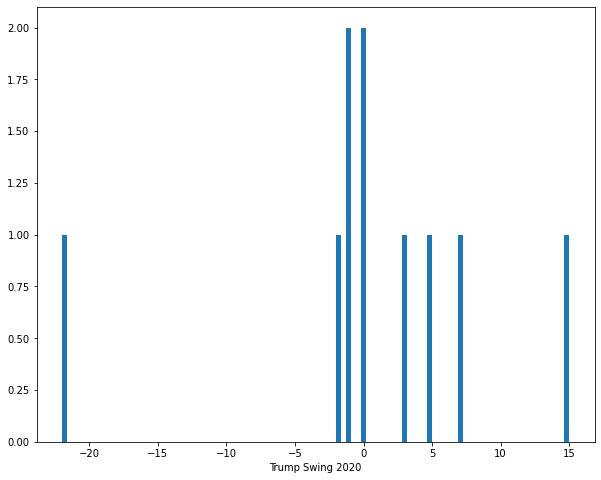

In [35]:
prescient16
prescient20_swings, prescient20_trump = predictions(selected16=prescient16)
prescient20_trump


So we see that the prescient pollsters think Biden is up by 7.0 points. But quite a few show a swing towards Trump (one outlier drags the average back). 

On the other hand, the calculation below shows that the deceived pollsters think Biden is up by nearly 9 points. 

Both seem like comfortable leads. 

However the deceived pollsters see a swing towards Biden of 3.4 points (!) and we simply don't see that in the prescient polls. 

Yeah, its a small sample. 


Fairleigh Dickinson -> Fairleigh Dickinson 
Public Religion  Institute/The Atlantic -> Public Religion  Institute
Remington  Group (R)/Axiom Strategies -> Remington  Group
Saint Leo  -> Saint Leo 
Politico/Morning Consult -> Morning Consult
Monmouth  -> Monmouth 
Roanoke  -> Roanoke 
Washington Post/GMU -> ABC News/Washington Post
Suffolk/USA Today -> Suffolk 
Baldwin Wallace  -> Baldwin Wallace 
Marquette Law School -> Marquette  Law School
Muhlenberg/Morning Call -> Muhlenberg 
SurveyUSA/KSTP-TV -> SurveyUSA

Trump advantage -8.76923076923077
Trump swing mean -3.4
Trump swing median -2.5


{'ABC News/Washington Post': -9,
 'Baldwin Wallace ': -5,
 'Fairleigh Dickinson ': -15,
 'Marquette  Law School': -5,
 'Monmouth ': -10,
 'Morning Consult': -7,
 'Muhlenberg ': -4,
 'Public Religion  Institute': -13,
 'Remington  Group': 5,
 'Roanoke ': -14,
 'Saint Leo ': -6,
 'Suffolk ': -4,
 'SurveyUSA': -27}

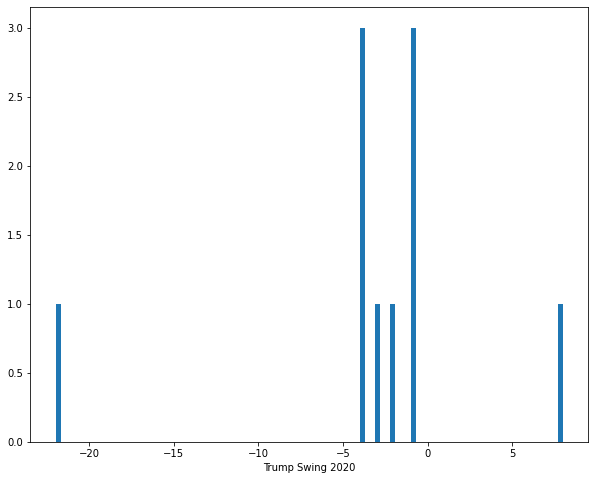

In [37]:
deceived20_swings, deceived20_trump = predictions(selected16=deceived16)
deceived20_trump

Text(0.5, 0, 'Swing to Trump')

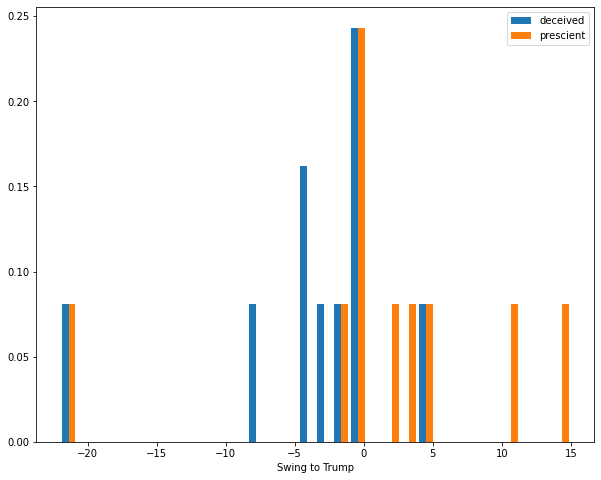

In [597]:
plt.hist([deceived20_swings,prescient20_swings], density=True, histtype='bar', bins=30)
plt.legend(['deceived','prescient'])
plt.xlabel('Swing to Trump')

And there you have the Halloween plot. Its hard not to look at this and think there are two groups of pollsters saying quite different things. And the orange guys were right last time around so...


So nothing, perhaps. This is a long way from a theory. But it might be a worry from the liberal perspective (at least relative to the anzatz that Biden has a 95% chance of winning, as currently predicted by the Economist/Gelman model). 



Text(0.5, 0, 'Trump advantage')

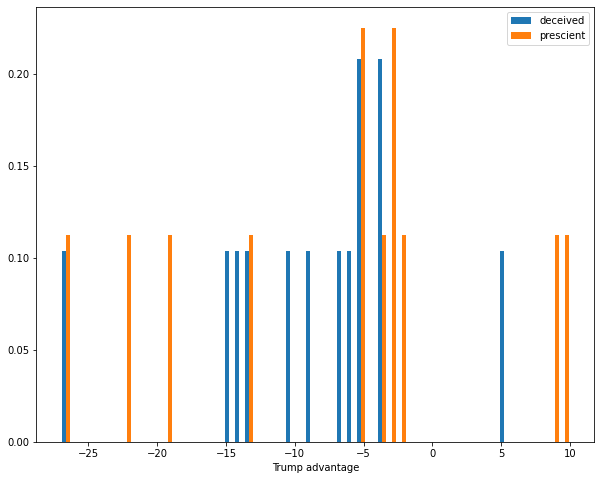

In [40]:

plt.hist([list(deceived20_trump.values()), list(prescient20_trump.values())], density=True, histtype='bar', bins=50)
plt.legend(['deceived','prescient'])
plt.xlabel('Trump advantage')

Who are the pollsters ... 

In [41]:
deceived20_trump

{'ABC News/Washington Post': -9,
 'Baldwin Wallace ': -5,
 'Fairleigh Dickinson ': -15,
 'Marquette  Law School': -5,
 'Monmouth ': -10,
 'Morning Consult': -7,
 'Muhlenberg ': -4,
 'Public Religion  Institute': -13,
 'Remington  Group': 5,
 'Roanoke ': -14,
 'Saint Leo ': -6,
 'Suffolk ': -4,
 'SurveyUSA': -27}

In [44]:
def show_pollster(selected20,lead):
  poll = polls20.loc[ (polls20['pollster']==selected20),:]
  plt.plot(poll['end.date'],poll['tmc'],'*')
  abs_lead = abs(lead)
  candidate = 'Biden' if lead<0 else 'Trump'
  plt.title(selected20+' ('+candidate+' by '+str(abs_lead)+')')
prescient20_trump

{'Christopher Newport ': -5,
 'DKC Analytics': -19,
 'Data Orbital': -2,
 'IBD/TIPP': -3,
 'NYT/Siena ': -5,
 'Quinnipiac ': -3,
 'Siena ': -22,
 'Suffolk ': -4,
 'SurveyUSA': -27,
 'TIPP': -13,
 'Y2 Analytics': 10,
 'YouGov': 9}

Want to poll watch? Why wouldn't you?

I've made it easier here...

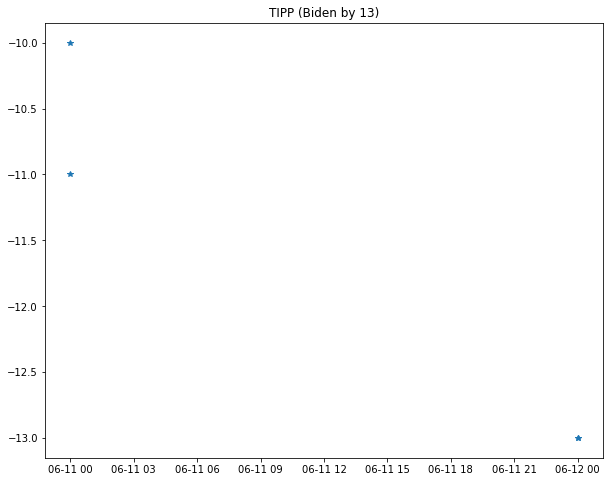

In [45]:
# Click this to show a random prescient pollster
import random 
pollster, swg = random.choice( list(prescient20_trump.items()) )
show_pollster(pollster,swg)

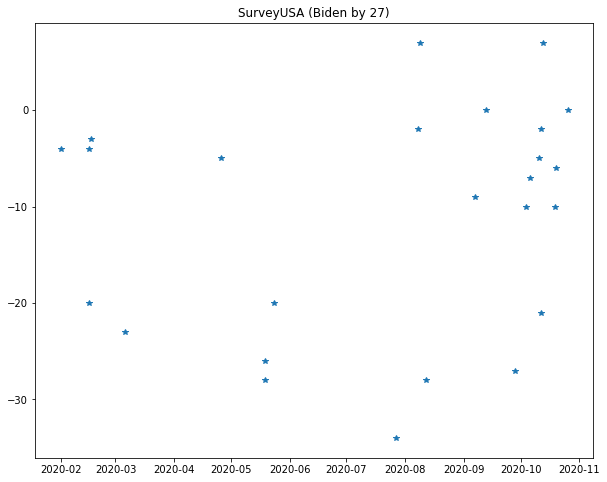

In [46]:
# Click this to show a random deceived pollster
import random 
pollster, swg = random.choice( list(deceived20_trump.items()) )
show_pollster(pollster,swg)